<a href="https://colab.research.google.com/github/PhuongAnh2212/midterm-DSP/blob/main/SER_SVM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install librosa scikit-learn numpy

In [3]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csav)

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import os

# Initialize the DataFrame
Ravdess = pd.DataFrame({
    'emotions': [],
    'path': []
})

scaler = MinMaxScaler(feature_range=(0, 1))

Ravdess_dir = "/content/drive/MyDrive/SpeechActors01-24"
for dir in os.listdir(Ravdess_dir):
    # Construct full path to the directory
    dir_path = os.path.join(Ravdess_dir, dir)
    # Ensure it's a directory
    if os.path.isdir(dir_path):
        for file in os.listdir(dir_path):
            # Check for valid audio file extensions
            if file.endswith(('.wav', '.mp3')):  # Add any other audio formats you expect
                audio_path = os.path.join(dir_path, file)
                id_arr = file.split('-')
                emo_id = id_arr[2]
                if emo_id == '01':
                    emo = 'neutral'
                elif emo_id == '02':
                    emo = 'calm'
                elif emo_id == '03':
                    emo = 'happy'
                elif emo_id == '04':
                    emo = 'sad'
                elif emo_id == '05':
                    emo = 'angry'
                elif emo_id == '06':
                    emo = 'fearful'
                elif emo_id == '07':
                    emo = 'disgust'
                else:
                    emo = 'surprised'
                new_data = pd.DataFrame({'emotions': [emo], 'path': [audio_path]})
                Ravdess = pd.concat([Ravdess, new_data], ignore_index=True)

Ravdess['emotions'] = pd.Categorical(Ravdess['emotions'])
print(Ravdess)


       emotions                                               path
0       neutral  /content/drive/MyDrive/SpeechActors01-24/Actor...
1       neutral  /content/drive/MyDrive/SpeechActors01-24/Actor...
2       neutral  /content/drive/MyDrive/SpeechActors01-24/Actor...
3          calm  /content/drive/MyDrive/SpeechActors01-24/Actor...
4         happy  /content/drive/MyDrive/SpeechActors01-24/Actor...
...         ...                                                ...
1447  surprised  /content/drive/MyDrive/SpeechActors01-24/Actor...
1448  surprised  /content/drive/MyDrive/SpeechActors01-24/Actor...
1449  surprised  /content/drive/MyDrive/SpeechActors01-24/Actor...
1450  surprised  /content/drive/MyDrive/SpeechActors01-24/Actor...
1451  surprised  /content/drive/MyDrive/SpeechActors01-24/Actor...

[1452 rows x 2 columns]


In [4]:
Ravdess['emotions'].value_counts()

,count
emotions,
angry,195
fearful,195
calm,194
disgust,193
happy,193
sad,193
surprised,192
neutral,97


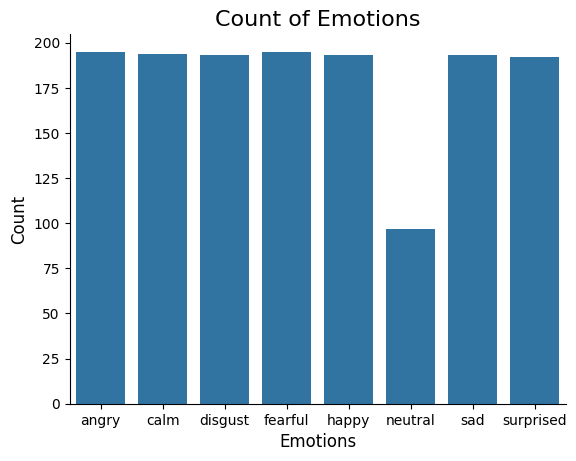

In [5]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=Ravdess, x='emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [6]:
def create_wave_plot (data_path, emo):
    audio, sr = librosa.load(data_path)
    plt.figure(figsize=(10,3))
    plt.title(f'Waveplot for audio with {emo} emotion', size=16)
    librosa.display.waveshow(audio, sr=sr)
    plt.show()

def show_melspectrogram (data_path, emo):
    S_db, sr = create_melspectrogram (data_path)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, y_axis='mel', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for audio with {emo} emotion')
    plt.tight_layout()
    plt.show()

def create_melspectrogram (data_path):
    audio, sr = librosa.load(data_path, sr=22050)
    n_frames = int(sr*1.2)
    start_frame = int(len(audio) // 2 - n_frames // 2)
    end_frame = start_frame + n_frames
    audio_cut = audio[start_frame:end_frame]
    S = librosa.feature.melspectrogram(y=audio_cut, sr=sr, n_mels=128, n_fft=1024, hop_length=512)
    S_db =librosa.power_to_db(S, ref=np.min)
    return S_db, sr

def create_mfcc (audio, sr):
    n_frames = int(sr*1.2)
    start_frame = int(len(audio) // 2 - n_frames // 2)
    end_frame = start_frame + n_frames
    audio_cut = audio[start_frame:end_frame]
    feature = np.mean(librosa.feature.mfcc(y=audio_cut,sr=sr,n_mfcc=40).T,axis=0)
    return feature

def create_origin_mfcc (data_path):
    S, sr = librosa.load(data_path)
    feature = create_mfcc(S,sr)
    return feature

def create_noise_mfcc (data_path):
    S, sr = librosa.load(data_path)
    noise_amp = 0.035*np.random.uniform()*np.amax(S)
    S = S + noise_amp*np.random.normal(size=S.shape[0])
    feature = create_mfcc(S,sr)
    return feature

def create_pitch_mfcc (data_path):
    S, sr = librosa.load(data_path)
    S = librosa.effects.pitch_shift(y=S, sr=sr, n_steps=0.7)
    feature = create_mfcc(S,sr)
    return feature

def create_stretch_mfcc (data_path):
    S, sr = librosa.load(data_path)
    S = librosa.effects.time_stretch(y=S, rate=0.85)
    feature = create_mfcc(S,sr)
    return feature

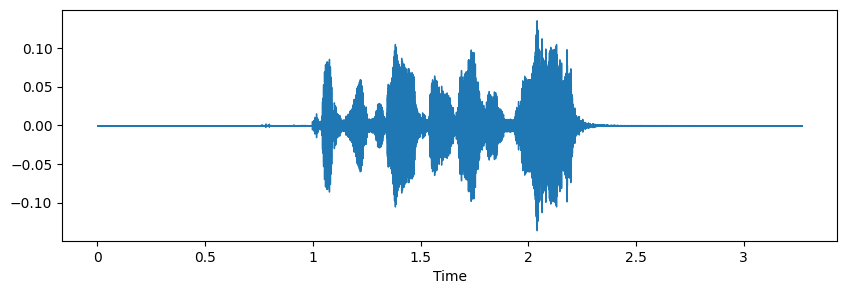

In [7]:
path_happy = np.array(Ravdess.path[Ravdess.emotions=='happy'])[1]
S, sr = librosa.load(path_happy)
plt.figure(figsize=(10,3))
librosa.display.waveshow(S, sr=sr)
plt.show()

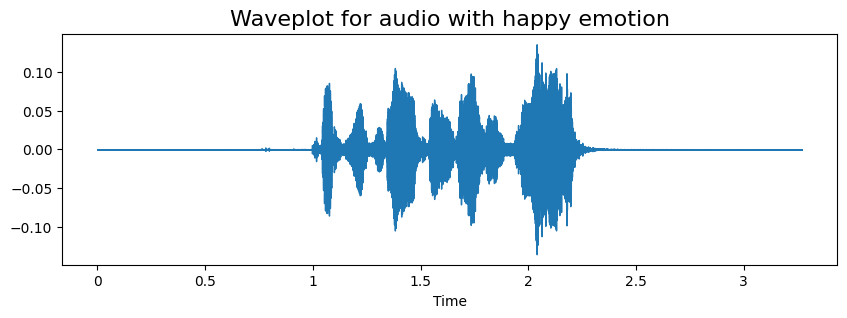

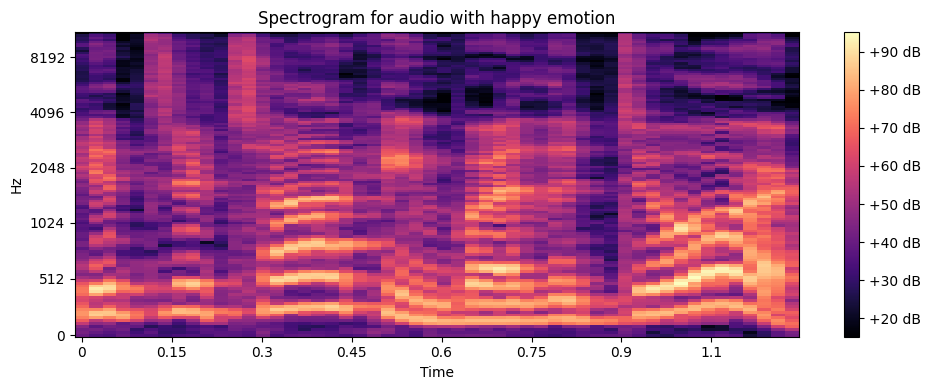

In [8]:
path_happy = np.array(Ravdess.path[Ravdess.emotions=='happy'])[1]
create_wave_plot(path_happy, 'happy')
show_melspectrogram(path_happy, 'happy')

In [9]:
origin = Ravdess['path'].apply(lambda x: create_origin_mfcc(x))
noise = Ravdess['path'].apply(lambda x: create_noise_mfcc(x))
pitch = Ravdess['path'].apply(lambda x: create_pitch_mfcc(x))
stretch = Ravdess['path'].apply(lambda x: create_stretch_mfcc(x))

# Optional: Convert to DataFrame for better handling
origin_df = pd.DataFrame(origin.tolist(), columns=[f'origin_mfcc_{i+1}' for i in range(40)])
noise_df = pd.DataFrame(noise.tolist(), columns=[f'noise_mfcc_{i+1}' for i in range(40)])
pitch_df = pd.DataFrame(pitch.tolist(), columns=[f'pitch_mfcc_{i+1}' for i in range(40)])
stretch_df = pd.DataFrame(stretch.tolist(), columns=[f'stretch_mfcc_{i+1}' for i in range(40)])

# Combine the features with the original DataFrame
Ravdess_features = pd.concat([Ravdess, origin_df, noise_df, pitch_df, stretch_df], axis=1)

# Display the combined DataFrame with features
Ravdess_features.head()

,emotions,path,origin_mfcc_1,origin_mfcc_2,origin_mfcc_3,origin_mfcc_4,origin_mfcc_5,origin_mfcc_6,origin_mfcc_7,origin_mfcc_8,...,stretch_mfcc_31,stretch_mfcc_32,stretch_mfcc_33,stretch_mfcc_34,stretch_mfcc_35,stretch_mfcc_36,stretch_mfcc_37,stretch_mfcc_38,stretch_mfcc_39,stretch_mfcc_40
0,neutral,/content/drive/MyDrive/SpeechActors01-24/Actor...,-473.526428,109.752647,-16.185368,10.694670,14.013962,-11.245950,-7.788402,-7.281178,...,-7.376739,-1.351522,-8.723264,-4.798397,-7.610008,-2.366807,-5.027410,-2.370217,-5.484387,3.633733
1,neutral,/content/drive/MyDrive/SpeechActors01-24/Actor...,-473.526428,109.752647,-16.185368,10.694670,14.013962,-11.245950,-7.788402,-7.281178,...,-7.376739,-1.351522,-8.723264,-4.798397,-7.610008,-2.366807,-5.027410,-2.370217,-5.484387,3.633733
2,neutral,/content/drive/MyDrive/SpeechActors01-24/Actor...,-451.727478,109.762779,-22.111015,14.244523,24.376575,-16.458254,-0.636611,-7.930946,...,-5.867043,-2.384844,-6.235919,-2.838249,-6.287262,-3.332661,-7.146607,-3.392708,-3.010031,5.730288
3,calm,/content/drive/MyDrive/SpeechActors01-24/Actor...,-674.753479,72.343399,4.330179,18.644970,19.647106,-0.767206,-2.321302,-4.963667,...,-2.005424,-2.655753,-5.107260,-3.704699,-5.713516,-0.599648,-2.047251,-2.050277,-3.630093,-1.844869
4,happy,/content/drive/MyDrive/SpeechActors01-24/Actor...,-394.908417,99.857597,-26.136364,7.415769,8.163462,-20.965498,-16.137737,-17.567383,...,6.085320,7.738131,3.466858,1.111846,-1.674803,-1.353887,2.863121,6.861430,3.670645,10.367949


In [10]:
from sklearn.preprocessing import OneHotEncoder

# Assuming `Ravdess_features` DataFrame contains the emotions column and MFCC features
ohe = OneHotEncoder()

# Fit and transform the emotions in the Ravdess DataFrame
y1 = ohe.fit_transform(Ravdess_features[['emotions']]).toarray()
# For other transformations, you can just concatenate the same labels,
# since they are the same for each transformation
y2 = y1
y3 = y1
y4 = y1

# Combine MFCC feature arrays into a single array
mfcc_data = np.concatenate([origin, noise, pitch, stretch])

# Concatenate the one-hot encoded labels
y = np.concatenate([y1, y2, y3, y4])

# Display the shape of the features and labels
print("MFCC Data Shape:", mfcc_data.shape)
print("One-Hot Encoded Labels Shape:", y.shape)

MFCC Data Shape: (5808,)
One-Hot Encoded Labels Shape: (5808, 8)


In [11]:
X = [x for x in mfcc_data]
X = np.array(X)
X.shape

(5808, 40)

In [12]:
# Define the list for the emotion labels
y_label = []

# Iterate through each one-hot encoded label in y
for i in range(len(y)):
    if y[i][0] == 1.0:
        y_label.append('angry')
    elif y[i][1] == 1.0:
        y_label.append('disgust')
    elif y[i][2] == 1.0:
        y_label.append('fearful')
    elif y[i][3] == 1.0:
        y_label.append('happy')
    elif y[i][4] == 1.0:
        y_label.append('neutral')
    elif y[i][5] == 1.0:
        y_label.append('sad')
    elif y[i][6] == 1.0:
        y_label.append('surprised')

# Convert the list of labels to a NumPy array
y_trans = np.array(y_label)

# Display the shape of the transformed labels
print("Transformed Labels Shape:", y_trans.shape)


Transformed Labels Shape: (5040,)


In [13]:
# Assuming X was created from your audio features
# And y_trans was generated as described previously

# Check the minimum size for both
min_samples = min(X.shape[0], y_trans.shape[0])

# Slice both X and y_trans to match the minimum size
X = X[:min_samples]
y_trans = y_trans[:min_samples]

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)

In [14]:
#Train model using SVM
model_SVM = SVC (C=1.0,kernel='rbf',random_state=42)
model_SVM.fit (X_train,y_train)

y_pred = model_SVM.predict (X_test)

print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.20      0.23      0.22       158
     disgust       0.00      0.00      0.00       145
     fearful       0.17      0.42      0.25       151
       happy       0.15      0.45      0.23       155
     neutral       0.00      0.00      0.00       160
         sad       0.00      0.00      0.00        83
   surprised       0.00      0.00      0.00       156

    accuracy                           0.17      1008
   macro avg       0.08      0.16      0.10      1008
weighted avg       0.08      0.17      0.11      1008



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Add cross-validation


In [15]:
pip install --upgrade librosa


In [16]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score

# Define your SVM model (adjust hyperparameters if needed)
model = SVC(kernel='linear', class_weight='balanced')

# Use Stratified K-Folds cross-validator
# Stratified ensures each fold has a similar class distribution
cv = StratifiedKFold(n_splits=5)

# Choose the scoring metric; accuracy is just one option (you can also use F1, precision, etc.)
scoring = make_scorer(accuracy_score)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)

# Print the accuracy for each fold and the mean accuracy
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean()}')

# Fit the model after cross-validation if you want to proceed with further testing
model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = model.predict(X_test)

# Now calculate the performance metrics on the test set
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


Cross-validation scores: [0.1511772  0.12143742 0.1191067  0.14019851 0.13523573]
Mean accuracy: 0.1334311129970082
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       158
     disgust       0.11      0.08      0.09       145
     fearful       0.20      0.17      0.18       151
       happy       0.13      0.12      0.12       155
     neutral       0.20      0.11      0.14       160
         sad       0.08      0.19      0.11        83
   surprised       0.19      0.20      0.19       156

    accuracy                           0.14      1008
   macro avg       0.15      0.14      0.14      1008
weighted avg       0.15      0.14      0.14      1008



In [ ]:
# In Colab, train and save the SVM model
from sklearn.svm import SVC
import joblib

# Assume X_train and y_train contain your training data
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Save the model
joblib.dump(svm_model, 'svm_model.pkl')
